In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

In [0]:
! pip install geopandas

In [0]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os
import tensorflow as tf
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_log_error

from datetime import datetime
from datetime import timedelta

from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [0]:
data_dir = "drive/My Drive/Classes/CSCE_5933_Deep_Learning/HW_12_Kaggle/Data/"

# 2. Preparing the training data

In [0]:
train_df = gpd.read_file("%strain.csv"%data_dir)
train_df["ConfirmedCases"] = train_df["ConfirmedCases"].astype("float")
train_df["Fatalities"] = train_df["Fatalities"].astype("float")
#The country_region got modified in the enriched dataset by @optimo, 
# so we have to apply the same change to this Dataframe to facilitate the merge.
train_df["Country_Region"] = [ row.Country_Region.replace("'","").strip(" ") if row.Province_State=="" else str(row.Country_Region+"_"+row.Province_State).replace("'","").strip(" ") for idx,row in train_df.iterrows()]

In [0]:
#Still using the enriched data from week 2 as there is everything required for the model's training
extra_data_df = gpd.read_file("%senriched_covid_19_week_2.csv"%data_dir)
extra_data_df["Country_Region"] = [country_name.replace("'","") for country_name in extra_data_df["Country_Region"]]
extra_data_df["restrictions"] = extra_data_df["restrictions"].astype("int")
extra_data_df["quarantine"] = extra_data_df["quarantine"].astype("int")
extra_data_df["schools"] = extra_data_df["schools"].astype("int")
extra_data_df["total_pop"] = extra_data_df["total_pop"].astype("float")
extra_data_df["density"] = extra_data_df["density"].astype("float")
extra_data_df["hospibed"] = extra_data_df["hospibed"].astype("float")
extra_data_df["lung"] = extra_data_df["lung"].astype("float")
extra_data_df["total_pop"] = extra_data_df["total_pop"]/max(extra_data_df["total_pop"])
extra_data_df["density"] = extra_data_df["density"]/max(extra_data_df["density"])
extra_data_df["hospibed"] = extra_data_df["hospibed"]/max(extra_data_df["hospibed"])
extra_data_df["lung"] = extra_data_df["lung"]/max(extra_data_df["lung"])
extra_data_df["age_100+"] = extra_data_df["age_100+"].astype("float")
extra_data_df["age_100+"] = extra_data_df["age_100+"]/max(extra_data_df["age_100+"])

extra_data_df = extra_data_df[["Country_Region","Date","restrictions","quarantine","schools","hospibed","lung","total_pop","density","age_100+"]]
extra_data_df.head()

,Country_Region,Date,restrictions,quarantine,schools,hospibed,lung,total_pop,density,age_100+
0,Afghanistan,2020-01-22,0,0,0,0.036232,0.329191,0.027046,0.002278,0.001411
1,Afghanistan,2020-01-23,0,0,0,0.036232,0.329191,0.027046,0.002278,0.001411
2,Afghanistan,2020-01-24,0,0,0,0.036232,0.329191,0.027046,0.002278,0.001411
3,Afghanistan,2020-01-25,0,0,0,0.036232,0.329191,0.027046,0.002278,0.001411
4,Afghanistan,2020-01-26,0,0,0,0.036232,0.329191,0.027046,0.002278,0.001411


In [0]:
train_df = train_df.merge(extra_data_df, how="left", on=['Country_Region','Date']).drop_duplicates()
train_df.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,geometry,restrictions,quarantine,schools,hospibed,lung,total_pop,density,age_100+
0,1,,Afghanistan,2020-01-22,0.0,0.0,None,0.0,0.0,0.0,0.036232,0.329191,0.027046,0.002278,0.001411
1,2,,Afghanistan,2020-01-23,0.0,0.0,None,0.0,0.0,0.0,0.036232,0.329191,0.027046,0.002278,0.001411
2,3,,Afghanistan,2020-01-24,0.0,0.0,None,0.0,0.0,0.0,0.036232,0.329191,0.027046,0.002278,0.001411
3,4,,Afghanistan,2020-01-25,0.0,0.0,None,0.0,0.0,0.0,0.036232,0.329191,0.027046,0.002278,0.001411
4,5,,Afghanistan,2020-01-26,0.0,0.0,None,0.0,0.0,0.0,0.036232,0.329191,0.027046,0.002278,0.001411


Still need to complete part of the data for dates past the 25th of March as the enriched dataset didn't go that far.

In [0]:
for country_region in train_df.Country_Region.unique():
    query_df = train_df.query("Country_Region=='"+country_region+"' and Date=='2020-03-25'")
    train_df.loc[(train_df["Country_Region"]==country_region) & (train_df["Date"]>"2020-03-25"),"total_pop"] = query_df.total_pop.values[0]
    train_df.loc[(train_df["Country_Region"]==country_region) & (train_df["Date"]>"2020-03-25"),"hospibed"] = query_df.hospibed.values[0]
    train_df.loc[(train_df["Country_Region"]==country_region) & (train_df["Date"]>"2020-03-25"),"density"] = query_df.density.values[0]
    train_df.loc[(train_df["Country_Region"]==country_region) & (train_df["Date"]>"2020-03-25"),"lung"] = query_df.lung.values[0]
    train_df.loc[(train_df["Country_Region"]==country_region) & (train_df["Date"]>"2020-03-25"),"age_100+"] = query_df["age_100+"].values[0]
    train_df.loc[(train_df["Country_Region"]==country_region) & (train_df["Date"]>"2020-03-25"),"restrictions"] = query_df.restrictions.values[0]
    train_df.loc[(train_df["Country_Region"]==country_region) & (train_df["Date"]>"2020-03-25"),"quarantine"] = query_df.quarantine.values[0]
    train_df.loc[(train_df["Country_Region"]==country_region) & (train_df["Date"]>"2020-03-25"),"schools"] = query_df.schools.values[0]

As I was using an enriched dataset during the Week 2 competition, I have to add the new countries to my dataframe and fill the missing data with median values.

In [0]:
median_pop = np.median(extra_data_df.total_pop)
median_hospibed = np.median(extra_data_df.hospibed)
median_density = np.median(extra_data_df.density)
median_lung = np.median(extra_data_df.lung)
median_centenarian_pop = np.median(extra_data_df["age_100+"])
#need to replace that with a joint using Pandas
print("The missing countries/region are:")
for country_region in train_df.Country_Region.unique():
    if extra_data_df.query("Country_Region=='"+country_region+"'").empty:
        print(country_region)
        
        train_df.loc[train_df["Country_Region"]==country_region,"total_pop"] = median_pop
        train_df.loc[train_df["Country_Region"]==country_region,"hospibed"] = median_hospibed
        train_df.loc[train_df["Country_Region"]==country_region,"density"] = median_density
        train_df.loc[train_df["Country_Region"]==country_region,"lung"] = median_lung
        train_df.loc[train_df["Country_Region"]==country_region,"age_100+"] = median_centenarian_pop
        train_df.loc[train_df["Country_Region"]==country_region,"restrictions"] = 0
        train_df.loc[train_df["Country_Region"]==country_region,"quarantine"] = 0
        train_df.loc[train_df["Country_Region"]==country_region,"schools"] = 0

The missing countries/region are:
Botswana
Burma
Burundi
Canada_Northwest Territories
Canada_Yukon
France_Saint Pierre and Miquelon
Kosovo
MS Zaandam
Malawi
Netherlands_Bonaire, Sint Eustatius and Saba
Sao Tome and Principe
Sierra Leone
South Sudan
United Kingdom_Anguilla
United Kingdom_British Virgin Islands
United Kingdom_Falkland Islands (Malvinas)
United Kingdom_Turks and Caicos Islands
West Bank and Gaza
Western Sahara


I create a new dataframe where I will only store 13-day trends for each location with the resulting numbers on the 14th day. The time periods extracted do not overlap on purpose.

In [0]:
from sklearn import linear_model
from sklearn import svm

train_df = train_df.query("Date>'2020-02-28'and Date<'2020-04-01'")

preds = []
for country in train_df.Country_Region.unique():
    for province in train_df.query(f"Country_Region=='{country}'").Province_State.unique():
        df = pd.DataFrame(train_df.query(f"Country_Region=='{country}' and Province_State=='{province}'"))
        dates = df["Date"].values
        df["Date"] = pd.to_datetime(df["Date"])
        df = df.sort_values(by="Date")
        df2 = df[["hospibed",
                 "lung", 
                 "total_pop", 
                 "density", 
                 "age_100+",
                 "ConfirmedCases", 
                 "Fatalities", 
                 ]]
        y = df2[["ConfirmedCases", "Fatalities"]].values
        cols = list(df.columns)
        x = df2.values
        for i, row in enumerate(x):
            x[i][cols.index("ConfirmedCases")] = x[i-1][cols.index("ConfirmedCases")]
            x[i][cols.index("Fatalities")] = x[i-1][cols.index("Fatalities")]
        y0 = []
        y1 = []
        for row in y:
            y0.append(row[0])
            y1.append(row[1])

        lin_reg = linear_model.LinearRegression().fit(x, y)
        ridge = linear_model.Ridge().fit(x, y)
        svr_cc = svm.SVR().fit(x, y0)
        svr_f =svm.SVR().fit(x, y1)

        for i, row in enumerate(x):
            lr = lin_reg.predict([row])
            r = ridge.predict([row])
            s_cc = svr_cc.predict([row])
            s_f = svr_f.predict([row])
            preds.append([country, 
                          province, 
                          df.iloc[i][cols.index("Date")].strftime("%Y-%m-%d"), 
                          lr[0][0], 
                          lr[0][1], 
                          r[0][0], 
                          r[0][1], 
                          s_cc[0], 
                          s_f[0], 
                          ])

preds2 = pd.DataFrame(preds, columns=["Country_Region", "Province_State", "Date", "lin_reg_cc", "lin_reg_f", "ridge_cc", "rige_f", "svr_cc", "svr_f"])
new_df = train_df.merge(preds2, how="left", on=['Country_Region','Province_State','Date']).drop_duplicates()
new_df.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,geometry,restrictions,quarantine,schools,hospibed,lung,total_pop,density,age_100+,lin_reg_cc,lin_reg_f,ridge_cc,rige_f,svr_cc,svr_f
0,39,,Afghanistan,2020-02-29,1.0,0.0,None,0.0,0.0,0.0,0.036232,0.329191,0.027046,0.002278,0.001411,10.620774,2.220446e-16,10.974668,0.011661,18.5,0.1
1,40,,Afghanistan,2020-03-01,1.0,0.0,None,0.0,0.0,0.0,0.036232,0.329191,0.027046,0.002278,0.001411,10.620774,2.220446e-16,10.974668,0.011661,18.5,0.1
2,41,,Afghanistan,2020-03-02,1.0,0.0,None,0.0,0.0,0.0,0.036232,0.329191,0.027046,0.002278,0.001411,10.620774,2.220446e-16,10.974668,0.011661,18.5,0.1
3,42,,Afghanistan,2020-03-03,1.0,0.0,None,0.0,0.0,0.0,0.036232,0.329191,0.027046,0.002278,0.001411,10.620774,2.220446e-16,10.974668,0.011661,18.5,0.1
4,43,,Afghanistan,2020-03-04,1.0,0.0,None,0.0,0.0,0.0,0.036232,0.329191,0.027046,0.002278,0.001411,10.620774,2.220446e-16,10.974668,0.011661,18.5,0.1


In [0]:
trend_df = pd.DataFrame(columns={"infection_trend","fatality_trend","quarantine_trend","school_trend","total_population","expected_cases","expected_fatalities"})

In [0]:
#Just getting rid of the first days to have a multiple of 7
#Makes it easier to generate the sequences
train_df = train_df.query("Date>'2020-01-22'and Date<'2020-04-01'")
days_in_sequence = 21

trend_list = []

with tqdm(total=len(list(train_df.Country_Region.unique()))) as pbar:
    for country in train_df.Country_Region.unique():
        for province in train_df.query(f"Country_Region=='{country}'").Province_State.unique():
            province_df = train_df.query(f"Country_Region=='{country}' and Province_State=='{province}'")
            
            #I added a quick hack to double the number of sequences
            #Warning: This will later create a minor leakage from the 
            # training set into the validation set.
            for i in range(0,len(province_df),int(days_in_sequence/3)):
                if i+days_in_sequence<=len(province_df):
                    #prepare all the temporal inputs
                    infection_trend = [float(x) for x in province_df[i:i+days_in_sequence-1].ConfirmedCases.values]
                    fatality_trend = [float(x) for x in province_df[i:i+days_in_sequence-1].Fatalities.values]
                    restriction_trend = [float(x) for x in province_df[i:i+days_in_sequence-1].restrictions.values]
                    quarantine_trend = [float(x) for x in province_df[i:i+days_in_sequence-1].quarantine.values]
                    school_trend = [float(x) for x in province_df[i:i+days_in_sequence-1].schools.values]

                    #preparing all the demographic inputs
                    total_population = float(province_df.iloc[i].total_pop)
                    density = float(province_df.iloc[i].density)
                    hospibed = float(province_df.iloc[i].hospibed)
                    lung = float(province_df.iloc[i].lung)
                    centenarian_pop = float(province_df.iloc[i]["age_100+"])

                    expected_cases = float(province_df.iloc[i+days_in_sequence-1].ConfirmedCases)
                    expected_fatalities = float(province_df.iloc[i+days_in_sequence-1].Fatalities)

                    trend_list.append({"infection_trend":infection_trend,
                                     "fatality_trend":fatality_trend,
                                     "restriction_trend":restriction_trend,
                                     "quarantine_trend":quarantine_trend,
                                     "school_trend":school_trend,
                                     "demographic_inputs":[total_population,density,hospibed,lung,centenarian_pop],
                                     "expected_cases":expected_cases,
                                     "expected_fatalities":expected_fatalities})
        pbar.update(1)
trend_df = pd.DataFrame(trend_list)

100%|██████████| 313/313 [00:14<00:00, 21.94it/s]


Preparing the inputs and shuffling the dataframe to make sure we have a bit of everything in our training and validation set.

In [0]:
trend_df["temporal_inputs"] = [np.asarray([trends["infection_trend"],trends["fatality_trend"],trends["restriction_trend"],trends["quarantine_trend"],trends["school_trend"]]) for idx,trends in trend_df.iterrows()]

trend_df = shuffle(trend_df)

In [0]:
trend_df.head()

,infection_trend,fatality_trend,restriction_trend,quarantine_trend,school_trend,demographic_inputs,expected_cases,expected_fatalities,temporal_inputs
234,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.014522985291841643, 0.00288567414663781, 0....",0.0,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1122,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.004773968945780786, 0.003607092683297262, 0...",0.0,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1099,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0013104779022430017, 0.0011390818999886091,...",0.0,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1173,"[22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 23....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.022486947401731724, 0.0037589702699624104, ...",149.0,0.0,"[[22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 23..."
1961,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.2322267255206195, 0.003607092683297262, 0.1...",0.0,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


Only keeping 25 sequences where the number of cases stays at 0, as there were way too many of these samples in our dataset.

In [0]:
i=0
temp_df = pd.DataFrame()
for idx,row in trend_df.iterrows():
    if sum(row.infection_trend)>0:
        temp_df = temp_df.append(row)
    else:
        if i<25:
            temp_df = temp_df.append(row)
            i+=1
trend_df = temp_df

In [0]:
trend_df.head()

,demographic_inputs,expected_cases,expected_fatalities,fatality_trend,infection_trend,quarantine_trend,restriction_trend,school_trend,temporal_inputs
234,"[0.014522985291841643, 0.00288567414663781, 0....",0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1122,"[0.004773968945780786, 0.003607092683297262, 0...",0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1099,"[0.0013104779022430017, 0.0011390818999886091,...",0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1173,"[0.022486947401731724, 0.0037589702699624104, ...",149.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 23....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 23..."
1961,"[0.2322267255206195, 0.003607092683297262, 0.1...",0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


Splitting my dataset with 90% for training and 10% for validation

In [0]:
sequence_length = 20
training_percentage = 0.9

In [0]:
training_item_count = int(len(trend_df)*training_percentage)
validation_item_count = len(trend_df)-int(len(trend_df)*training_percentage)
training_df = trend_df[:training_item_count]
validation_df = trend_df[training_item_count:]

In [0]:
X_temporal_train = np.asarray(np.transpose(np.reshape(np.asarray([np.asarray(x) for x in training_df["temporal_inputs"].values]),(training_item_count,5,sequence_length)),(0,2,1) )).astype(np.float32)
X_demographic_train = np.asarray([np.asarray(x) for x in training_df["demographic_inputs"]]).astype(np.float32)
Y_cases_train = np.asarray([np.asarray(x) for x in training_df["expected_cases"]]).astype(np.float32)
Y_fatalities_train = np.asarray([np.asarray(x) for x in training_df["expected_fatalities"]]).astype(np.float32)

In [0]:
X_temporal_test = np.asarray(np.transpose(np.reshape(np.asarray([np.asarray(x) for x in validation_df["temporal_inputs"]]),(validation_item_count,5,sequence_length)),(0,2,1)) ).astype(np.float32)
X_demographic_test = np.asarray([np.asarray(x) for x in validation_df["demographic_inputs"]]).astype(np.float32)
Y_cases_test = np.asarray([np.asarray(x) for x in validation_df["expected_cases"]]).astype(np.float32)
Y_fatalities_test = np.asarray([np.asarray(x) for x in validation_df["expected_fatalities"]]).astype(np.float32)

# 3. Build the model

The model is very simple in terms of architecture. The only difference from what could traditionally be seen is that it has two outputs so we can have two different losses (one for the expected number of cases and for the expected number of fatalities).

![Diagram-Covid-model.png](attachment:Diagram-Covid-model.png)

In [0]:
#temporal input branch
temporal_input_layer = Input(shape=(sequence_length,5))
main_rnn_layer = layers.LSTM(64, return_sequences=True, recurrent_dropout=0.2)(temporal_input_layer)

#demographic input branch
demographic_input_layer = Input(shape=(5))
demographic_dense = layers.Dense(16)(demographic_input_layer)
demographic_dropout = layers.Dropout(0.2)(demographic_dense)

#cases output branch
rnn_c = layers.LSTM(32)(main_rnn_layer)
merge_c = layers.Concatenate(axis=-1)([rnn_c,demographic_dropout])
dense_c = layers.Dense(128)(merge_c)
dropout_c = layers.Dropout(0.3)(dense_c)
cases = layers.Dense(1, activation=layers.LeakyReLU(alpha=0.1),name="cases")(dropout_c)

#fatality output branch
rnn_f = layers.LSTM(32)(main_rnn_layer)
merge_f = layers.Concatenate(axis=-1)([rnn_f,demographic_dropout])
dense_f = layers.Dense(128)(merge_f)
dropout_f = layers.Dropout(0.3)(dense_f)
fatalities = layers.Dense(1, activation=layers.LeakyReLU(alpha=0.1), name="fatalities")(dropout_f)


model = Model([temporal_input_layer,demographic_input_layer], [cases,fatalities])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 20, 5)]      0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 20, 64)       17920       input_3[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 16)           96          input_4[0][0]                    
____________________________________________________________________________________________

In [0]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1, factor=0.6),
             EarlyStopping(monitor='val_loss', patience=20),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
model.compile(loss=[tf.keras.losses.MeanSquaredLogarithmicError(),tf.keras.losses.MeanSquaredLogarithmicError()], optimizer="adam")

In [0]:
history = model.fit([X_temporal_train,X_demographic_train], [Y_cases_train, Y_fatalities_train], 
          epochs = 250, 
          batch_size = 16, 
          validation_data=([X_temporal_test,X_demographic_test],  [Y_cases_test, Y_fatalities_test]), 
          callbacks=callbacks)

Epoch 1/250
61/61 [==============================] - 3s 52ms/step - loss: 10.4686 - cases_loss: 9.1611 - fatalities_loss: 1.3075 - val_loss: 6.2808 - val_cases_loss: 5.4643 - val_fatalities_loss: 0.8165 - lr: 0.0010
Epoch 2/250
61/61 [==============================] - 2s 36ms/step - loss: 4.8380 - cases_loss: 3.9790 - fatalities_loss: 0.8590 - val_loss: 4.1581 - val_cases_loss: 3.6155 - val_fatalities_loss: 0.5425 - lr: 0.0010
Epoch 3/250
61/61 [==============================] - 2s 37ms/step - loss: 3.5597 - cases_loss: 2.8481 - fatalities_loss: 0.7116 - val_loss: 3.2114 - val_cases_loss: 2.7722 - val_fatalities_loss: 0.4391 - lr: 0.0010
Epoch 4/250
61/61 [==============================] - 2s 36ms/step - loss: 2.7553 - cases_loss: 2.2419 - fatalities_loss: 0.5134 - val_loss: 2.6841 - val_cases_loss: 2.2584 - val_fatalities_loss: 0.4257 - lr: 0.0010
Epoch 5/250
61/61 [==============================] - 2s 35ms/step - loss: 2.3851 - cases_loss: 1.8890 - fatalities_loss: 0.4961 - val_loss:

# 4. Performance during training

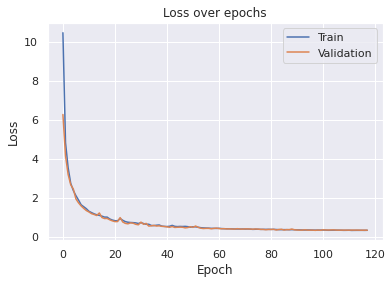

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

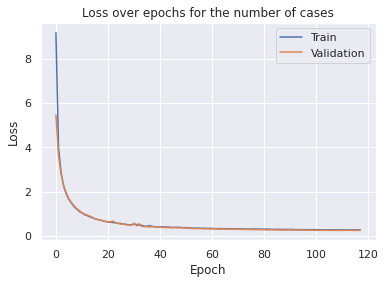

In [0]:
plt.plot(history.history['cases_loss'])
plt.plot(history.history['val_cases_loss'])
plt.title('Loss over epochs for the number of cases')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

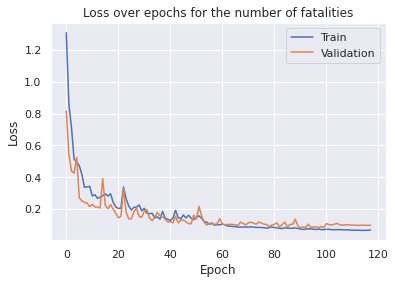

In [0]:
plt.plot(history.history['fatalities_loss'])
plt.plot(history.history['val_fatalities_loss'])
plt.title('Loss over epochs for the number of fatalities')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

# 5. Generate predictions using the model

We can quickly check the quality of the predictions... One thing is clear, there is room for improvement!

In [0]:
model.load_weights("best_model.h5")

In [0]:
predictions = model.predict([X_temporal_test,X_demographic_test])

I only display what I call "temporal" inputs as we're simply trying to have a feeling of how well our model is fitting the trends.

In [0]:
display_limit = 30
for inputs, pred_cases, exp_cases, pred_fatalities, exp_fatalities in zip(X_temporal_test,predictions[0][:display_limit], Y_cases_test[:display_limit], predictions[1][:display_limit], Y_fatalities_test[:display_limit]):
    print("================================================")
    print(inputs)
    print("Expected cases:", exp_cases, " Prediction:", pred_cases[0], "Expected fatalities:", exp_fatalities, " Prediction:", pred_fatalities[0] )

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]
Expected cases: 1.0  Prediction: 1.1433237 Expected fatalities: 0.0  Prediction: -0.18004407
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 2.  0.  0.  0.  0.]
 [ 8.  0.  0.  0.  0.]
 [ 8.  0.  0.  0.  0.]
 [10.  0.  0.  0.  0.]
 [10.  0.  0.  0.  0.]
 [12.  0.  0.  0.  0.]]
Expected cases: 13.0  Prediction: 15.323761 Expected fatalities: 0.0  Prediction: -0.

# 6. Apply the model to predict future trends

The following functions will be used to get the 13 previous days from a given date and demographic information, predict the number of cases and fatalities, before iterating again. Therefore, it will use the prediction for the next day as part of the data for the one afterwards.

In [0]:
#Will retrieve the number of cases and fatalities for the past 6 days from the given date
def build_inputs_for_date(country, province, date, df):
    start_date = date - timedelta(days=20)
    end_date = date - timedelta(days=1)
    
    str_start_date = start_date.strftime("%Y-%m-%d")
    str_end_date = end_date.strftime("%Y-%m-%d")
    df = df.query("Country_Region=='"+country+"' and Province_State=='"+province+"' and Date>='"+str_start_date+"' and Date<='"+str_end_date+"'")
    
    #preparing the temporal inputs
    temporal_input_data = np.transpose(np.reshape(np.asarray([df["ConfirmedCases"],
                                                 df["Fatalities"],
                                                 df["restrictions"],
                                                 df["quarantine"],
                                                 df["schools"]]),
                                     (5,sequence_length)), (1,0) ).astype(np.float32)
    
    #preparing all the demographic inputs
    total_population = float(province_df.iloc[i].total_pop)
    density = float(province_df.iloc[i].density)
    hospibed = float(province_df.iloc[i].hospibed)
    lung = float(province_df.iloc[i].lung)
    centenarian_pop = float(province_df.iloc[i]["age_100+"])
    demographic_input_data = [total_population,density,hospibed,lung,centenarian_pop]
    
    return [np.array([temporal_input_data]), np.array([demographic_input_data])]

In [0]:
#Take a dataframe in input, will do the predictions and return the dataframe with extra rows
#containing the predictions
def predict_for_region(country, province, df):
    begin_prediction = "2020-04-01"
    start_date = datetime.strptime(begin_prediction,"%Y-%m-%d")
    end_prediction = "2020-05-14"
    end_date = datetime.strptime(end_prediction,"%Y-%m-%d")
    
    date_list = [start_date + timedelta(days=x) for x in range((end_date-start_date).days+1)]
    for date in date_list:
        input_data = build_inputs_for_date(country, province, date, df)
        result = model.predict(input_data)
        
        #just ensuring that the outputs is
        #higher than the previous counts
        result[0] = np.round(result[0])
        if result[0]<input_data[0][0][-1][0]:
            result[0]=np.array([[input_data[0][0][-1][0]]])
        
        result[1] = np.round(result[1])
        if result[1]<input_data[0][0][-1][1]:
            result[1]=np.array([[input_data[0][0][-1][1]]])
        
        #We assign the quarantine and school status
        #depending on previous values
        #e.g Once a country is locked, it will stay locked until the end
        df = df.append({"Country_Region":country, 
                        "Province_State":province, 
                        "Date":date.strftime("%Y-%m-%d"), 
                        "restrictions": 1 if any(input_data[0][0][2]) else 0,
                        "quarantine": 1 if any(input_data[0][0][3]) else 0,
                        "schools": 1 if any(input_data[0][0][4]) else 0,
                        "total_pop": input_data[1][0],
                        "density": input_data[1][0][1],
                        "hospibed": input_data[1][0][2],
                        "lung": input_data[1][0][3],
                        "age_100+": input_data[1][0][4],
                        "ConfirmedCases":round(result[0][0][0]),	
                        "Fatalities":round(result[1][0][0])},
                       ignore_index=True)
    return df

In [0]:
#The functions that are called here need to optimise, sorry about that!
copy_df = train_df
with tqdm(total=len(list(copy_df.Country_Region.unique()))) as pbar:
    for country in copy_df.Country_Region.unique():
        for province in copy_df.query("Country_Region=='"+country+"'").Province_State.unique():
            copy_df = predict_for_region(country, province, copy_df)
        pbar.update(1)

100%|██████████| 313/313 [22:33<00:00,  4.33s/it]


# 7. Check the model's performance for the beginning of April

In [0]:
groundtruth_df = gpd.read_file("%strain.csv"%data_dir)

groundtruth_df["ConfirmedCases"] = groundtruth_df["ConfirmedCases"].astype("float")
groundtruth_df["Fatalities"] = groundtruth_df["Fatalities"].astype("float")
#The country_region got modifying in the enriched dataset by @optimo, 
# so we have to apply the same change to this Dataframe.
groundtruth_df["Country_Region"] = [ row.Country_Region.replace("'","").strip(" ") if row.Province_State=="" else str(row.Country_Region+"_"+row.Province_State).replace("'","").strip(" ") for idx,row in groundtruth_df.iterrows()]

last_date = groundtruth_df.Date.unique()[-1]

In [0]:
#to remove annoying warnings from pandas
pd.options.mode.chained_assignment = None

def get_RMSLE_per_region(region, groundtruth_df, display_only=False):
    groundtruth_df["ConfirmedCases"] = groundtruth_df["ConfirmedCases"].astype("float")
    groundtruth_df["Fatalities"] = groundtruth_df["Fatalities"].astype("float")
    
    #we only take data until the 30th of March 2020 as the groundtruth was not available for later dates.
    groundtruth = groundtruth_df.query("Country_Region=='"+region+"' and Date>='2020-04-01' and Date<='"+last_date+"'")
    predictions = copy_df.query("Country_Region=='"+region+"' and Date>='2020-04-01' and Date<='"+last_date+"'")
    
    RMSLE_cases = np.sqrt(mean_squared_log_error( groundtruth.ConfirmedCases.values, predictions.ConfirmedCases.values ))
    RMSLE_fatalities = np.sqrt(mean_squared_log_error( groundtruth.Fatalities.values, predictions.Fatalities.values ))
    
    if display_only:
        print(region)
        print("RMSLE on cases:",np.mean(RMSLE_cases))
        print("RMSLE on fatalities:",np.mean(RMSLE_fatalities))
    else:
        return RMSLE_cases, RMSLE_fatalities

In [0]:
def get_RMSLE_for_all_regions(groundtruth_df):
    RMSLE_cases_list = []
    RMSLE_fatalities_list = []
    for region in groundtruth_df.Country_Region.unique():
        RMSLE_cases, RMSLE_fatalities = get_RMSLE_per_region(region, groundtruth_df, False)
        RMSLE_cases_list.append(RMSLE_cases)
        RMSLE_fatalities_list.append(RMSLE_fatalities)
    print("RMSLE on cases:",np.mean(RMSLE_cases_list))
    print("RMSLE on fatalities:",np.mean(RMSLE_fatalities_list))

We can first check whether one of the outputs is globally harder to predict than the other.

In [0]:
get_RMSLE_for_all_regions(groundtruth_df)

RMSLE on cases: 0.7466539461129823
RMSLE on fatalities: 0.48544315844418245


Now, let's check how we are performing on two groups:
* Countries known to have an outbreak
* Countries with relatively "few" cases

In [0]:
badly_affected_countries = ["France","Italy","United Kingdom","Spain","Iran","Germany"]
for country in badly_affected_countries:
    get_RMSLE_per_region(country, groundtruth_df, display_only=True)

France
RMSLE on cases: 0.6961246899074823
RMSLE on fatalities: 1.0510802347065622
Italy
RMSLE on cases: 0.2685610258644182
RMSLE on fatalities: 0.3340488664660103
United Kingdom
RMSLE on cases: 0.845392961013352
RMSLE on fatalities: 1.2877682749981234
Spain
RMSLE on cases: 0.40263812936128207
RMSLE on fatalities: 0.5162169335548258
Iran
RMSLE on cases: 0.34276516583359734
RMSLE on fatalities: 0.3020168653811389
Germany
RMSLE on cases: 0.4219019506261444
RMSLE on fatalities: 0.9878457356967641


In [0]:
healthy_countries = ["Taiwan*","Singapore","Kenya","Slovenia","Portugal", "Israel"]
for country in healthy_countries:
    get_RMSLE_per_region(country, groundtruth_df, display_only=True)

Taiwan*
RMSLE on cases: 0.7030283027761562
RMSLE on fatalities: 0.670750472341094
Singapore
RMSLE on cases: 0.5122171433427216
RMSLE on fatalities: 0.6136182758949047
Kenya
RMSLE on cases: 0.5494670532865783
RMSLE on fatalities: 0.770331601170829
Slovenia
RMSLE on cases: 0.07974685665982925
RMSLE on fatalities: 0.19267899658508306
Portugal
RMSLE on cases: 0.5579846642133299
RMSLE on fatalities: 0.2844178113778824
Israel
RMSLE on cases: 0.5440620419811678
RMSLE on fatalities: 0.32816123444268985


# 8. Outputs: Observing the curves

I am using the original training CSV file instead of the enriched dataset as it is up-to-date with the latest stats from this week.

In [0]:
def display_comparison(region,groundtruth_df):
    groundtruth = groundtruth_df.query("Country_Region=='"+region+"' and Date>='2020-04-01' and Date<='2020-04-15'")
    prediction = copy_df.query("Country_Region=='"+region+"' and Date>='2020-04-01' and Date<='2020-04-15'")
    
    plt.plot(groundtruth.ConfirmedCases.values)
    plt.plot(prediction.ConfirmedCases.values)
    plt.title("Comparison between the actual data and our predictions for the number of cases")
    plt.ylabel('Number of cases')
    plt.xlabel('Date')
    plt.xticks(range(len(prediction.Date.values)),prediction.Date.values,rotation='vertical')
    plt.legend(['Groundtruth', 'Prediction'], loc='best')
    plt.show()
    
    plt.plot(groundtruth.Fatalities.values)
    plt.plot(prediction.Fatalities.values)
    plt.title("Comparison between the actual data and our predictions for the number of fatalities")
    plt.ylabel('Number of fatalities')
    plt.xlabel('Date')
    plt.xticks(range(len(prediction.Date.values)),prediction.Date.values,rotation='vertical')
    plt.legend(['Groundtruth', 'Prediction'], loc='best')
    plt.show()

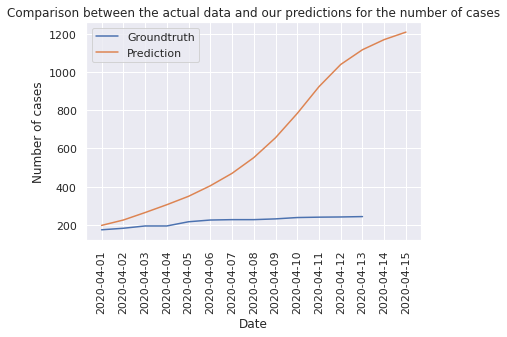

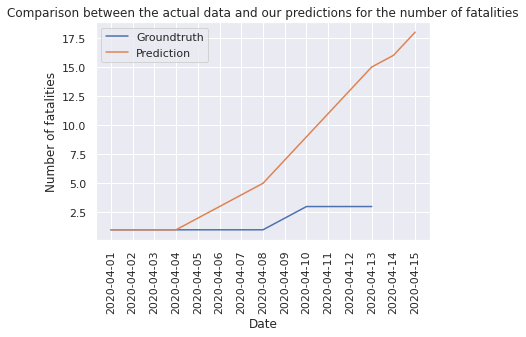

In [0]:
display_comparison("Canada_Newfoundland and Labrador", groundtruth_df)

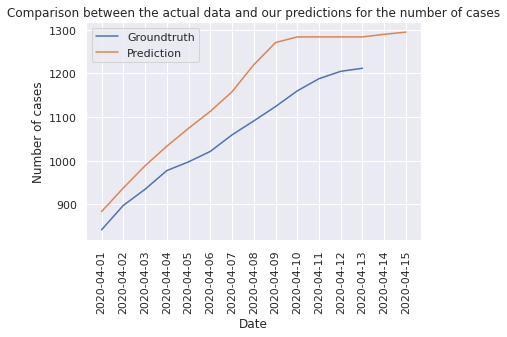

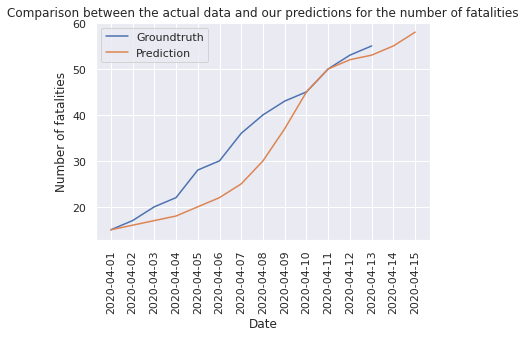

In [0]:
display_comparison("Slovenia", groundtruth_df)

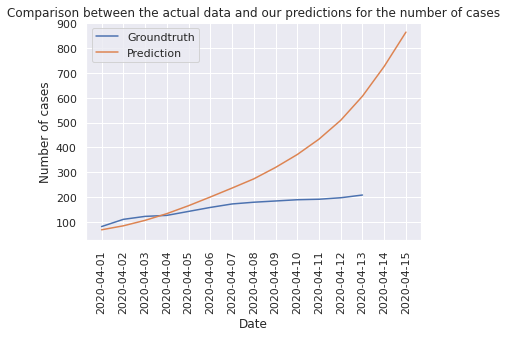

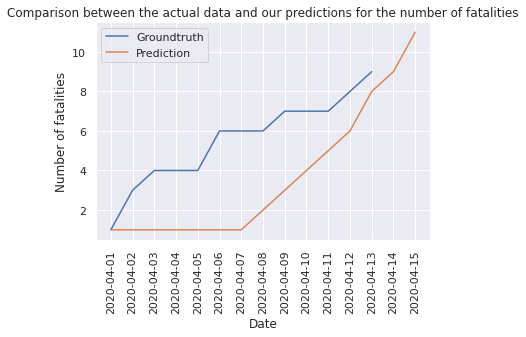

In [0]:
display_comparison("Kenya", groundtruth_df)

Now let's see how well the model perform on a much longer period.

In [0]:
def display_long_term_prediction(region,groundtruth_df):
    groundtruth = groundtruth_df.query("Country_Region=='"+region+"' and Date>='2020-04-01' and Date<='2020-04-15'")
    prediction = copy_df.query("Country_Region=='"+region+"' and Date>='2020-04-01' and Date<='2020-05-14'")
    
    plt.plot(groundtruth.ConfirmedCases.values)
    plt.plot(prediction.ConfirmedCases.values)
    plt.title("Comparison between the actual data and our predictions for the number of cases")
    plt.ylabel('Number of cases')
    plt.xlabel('Date')
    plt.xticks(range(len(prediction.Date.values)),prediction.Date.values,rotation='vertical')
    plt.legend(['Groundtruth', 'Prediction'], loc='best')
    plt.show()
    
    plt.plot(groundtruth.Fatalities.values)
    plt.plot(prediction.Fatalities.values)
    plt.title("Comparison between the actual data and our predictions for the number of fatalities")
    plt.ylabel('Number of fatalities')
    plt.xlabel('Date')
    plt.xticks(range(len(prediction.Date.values)),prediction.Date.values,rotation='vertical')
    plt.legend(['Groundtruth', 'Prediction'], loc='best')
    plt.show()

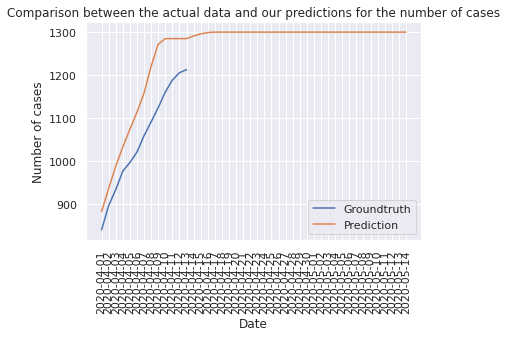

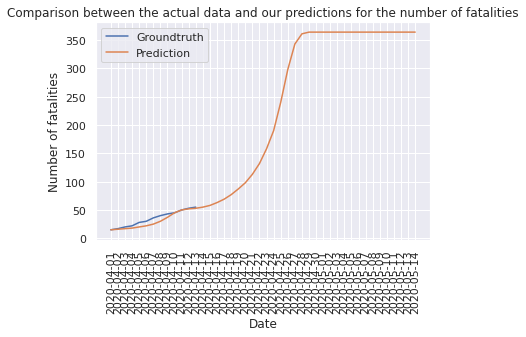

In [0]:
display_long_term_prediction("Slovenia", groundtruth_df)

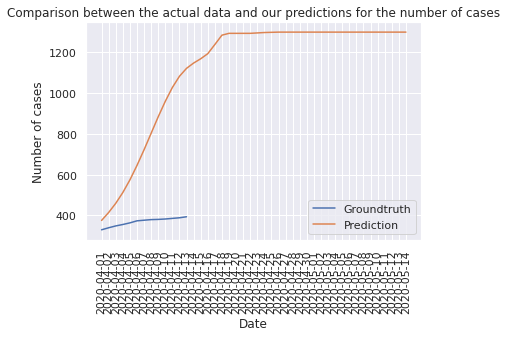

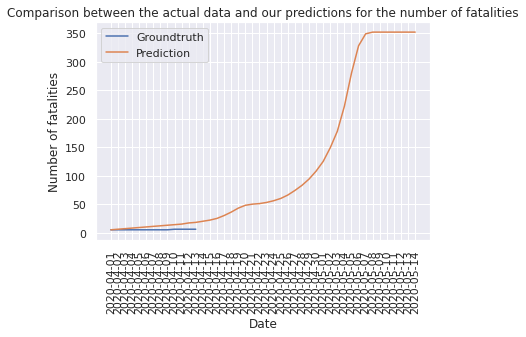

In [0]:
display_long_term_prediction("Taiwan*", groundtruth_df)

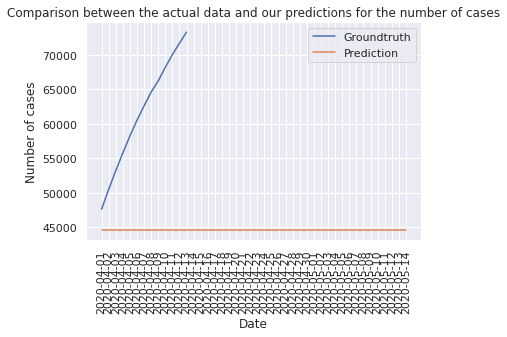

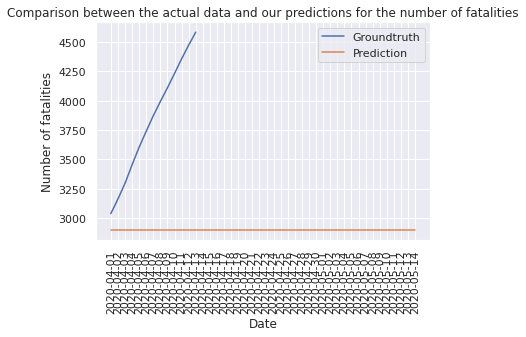

In [0]:
display_long_term_prediction("Iran", groundtruth_df)

# 9. Generating the submission file

In [0]:
test_df = gpd.read_file("%stest.csv"%data_dir)
#The country_region got modifying in the enriched dataset by @optimo, 
# so we have to apply the same change to the test Dataframe.
test_df["Country_Region"] = [ row.Country_Region if row.Province_State=="" else row.Country_Region+"_"+row.Province_State for idx,row in test_df.iterrows() ]
test_df.head()

,ForecastId,Province_State,Country_Region,Date,geometry
0,1,,Afghanistan,2020-04-02,None
1,2,,Afghanistan,2020-04-03,None
2,3,,Afghanistan,2020-04-04,None
3,4,,Afghanistan,2020-04-05,None
4,5,,Afghanistan,2020-04-06,None


Just need to do this little trick to extract the relevant date and the forecastId and add that to the submission file.

In [0]:
submission_df = pd.DataFrame(columns=["ForecastId","ConfirmedCases","Fatalities"])
with tqdm(total=len(test_df)) as pbar:
    for idx, row in test_df.iterrows():
        #Had to remove single quotes because of countries like Cote D'Ivoire for example
        country_region = row.Country_Region.replace("'","").strip(" ")
        province_state = row.Province_State.replace("'","").strip(" ")
        item = copy_df.query("Country_Region=='"+country_region+"' and Province_State=='"+province_state+"' and Date=='"+row.Date+"'")
        submission_df = submission_df.append({"ForecastId":row.ForecastId,
                                              "ConfirmedCases":int(item.ConfirmedCases.values[0]),
                                              "Fatalities":int(item.Fatalities.values[0])},
                                             ignore_index=True)
        pbar.update(1)

100%|██████████| 13459/13459 [03:05<00:00, 72.63it/s]


In [0]:
submission_df.sample(20)

,ForecastId,ConfirmedCases,Fatalities
10663,10664,3929,420
880,881,1299,71
1347,1348,622,1
6915,6916,1301,33
9957,9958,1651,412
8751,8752,2245,413
11882,11883,4963,420
3481,3482,1295,12
13086,13087,25150,1789
5551,5552,1314,145


In [0]:
submission_df.to_csv("submission.csv",index=False)

# 10. Conclusion

As there is still "little" data available for such kind of model, it was clearly an ambitious approach but I was curious to see how far we could go with such solution. It appears that the model was reasonably good at predicting the earlier stages of the spread when the numbers are still in the few hundreds, but then it seems to plateau far too early. It also appears to be performing awfully in countries when the outbreaks are already at an advanced stage. 
When looking back at the version notes, it seems that adding information about the regions improved the model's performance in a minor with significant manner. Information about the restrictions on populations over time showed more impact than demographic information such as the number of hospital beds or density of population.
While many other models have demonstrated far better results, I think this "naive" model could be interesting on the long run as more data become available, mostly due to how easy it is to integrate more new inputs to the model.

### If you found this notebook helpful, please give it an upvote. It will be greatly appreciated!